<a href="https://colab.research.google.com/github/shanky474/pfizer_case_study_customer_churn/blob/main/ML_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
data_encoded = pd.read_csv(r'drive/MyDrive/Pfizer_Assessment/Feature_Store/Telco-Customer-Churn-Features.csv')

In [3]:
data_encoded.head()

,SeniorCitizen,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,0,1,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,0,0,1,1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,1,0,1,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,0,0,1,1,0,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0


In [4]:
data_encoded['Churn'].value_counts()

,count
Churn,
0,5163
1,1869


Class imbalance noted for target variable hence using upsampling to correct it.

In [5]:
from sklearn.utils import resample

# Separate majority and minority classes
data_encoded_majority = data_encoded[data_encoded.Churn==0]
data_encoded_minority = data_encoded[data_encoded.Churn==1]

# Upsample minority class
data_encoded_minority_upsampled = resample(data_encoded_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=	5163,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_encoded_upsampled = pd.concat([data_encoded_majority, data_encoded_minority_upsampled])

# Display new class counts
data_encoded_upsampled.Churn.value_counts()

,count
Churn,
0,5163
1,5163


Create model Tracker

In [6]:

tracker = pd.DataFrame(columns=['Model','accuracy','precision','recall','f1_score','best_params','roc_auc_score','timestamp'])

Split data into train, validation, testing

In [7]:
X = data_encoded_upsampled.drop(['Churn'], axis=1)
Y = data_encoded_upsampled['Churn']


# Shuffles and splits into 60%, 20%, 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101, stratify=Y)
# train, val, test = np.split(data_encoded.sample(frac=1, random_state=42),
#                            [int(.6*len(data_encoded)), int(.8*len(data_encoded))])

Trying Logistic Regression for classification

In [8]:
model = LogisticRegression()

In [9]:
# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga'] # SAGA supports l1 and l2
}
# Apply Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

Predict output as well as probablities using the best Logistic Regression estimator derived from GridSearch

In [10]:
y_test_pred_log_res = grid_search.best_estimator_.predict(X_test)

In [11]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_log_res = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [12]:
confusion_matrix(y_test, y_test_pred_log_res)

array([[1136,  413],
       [ 311, 1238]])

<Axes: >

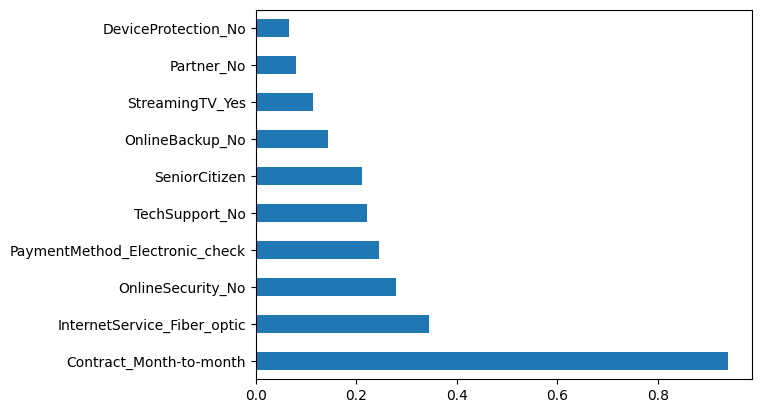

In [18]:
# To get the weights of all the variables
weights = pd.Series(grid_search.best_estimator_.coef_[0],
                 index=X.columns.values)
weights.sort_values(ascending = False)[:10].plot(kind='barh')

<Axes: >

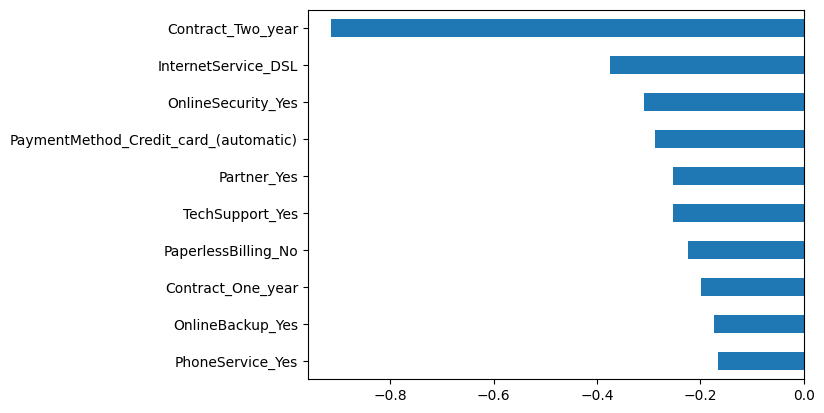

In [19]:
weights.sort_values(ascending = False)[-10:].plot(kind='barh')

In [16]:
# New row data as a list or Series
new_row_data = ['Logistic Regression',
                accuracy_score(y_test, y_test_pred_log_res),
                precision_score(y_test, y_test_pred_log_res),
                recall_score(y_test, y_test_pred_log_res),
                f1_score(y_test, y_test_pred_log_res),
                grid_search.best_params_,
                grid_search.best_score_,
                datetime.datetime.now()]

# Add the new row
tracker.loc[len(tracker)] = new_row_data

Now we try Decision tree classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
clf_model = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 100),
    'criterion': ['gini', 'entropy']
}

# Define parameter grid
grid_search = GridSearchCV(
    estimator=clf_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', # Use a relevant scoring metric
    n_jobs=-1 # Use all available processors
)


grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_split': range(2, 100)},
             scoring='accuracy')

In [21]:
# Make predictions
y_test_pred_dec_tree = grid_search.best_estimator_.predict(X_test)

In [22]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_dec_tree = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [23]:
confusion_matrix(y_test, y_test_pred_dec_tree)

array([[1158,  391],
       [ 292, 1257]])

<Axes: >

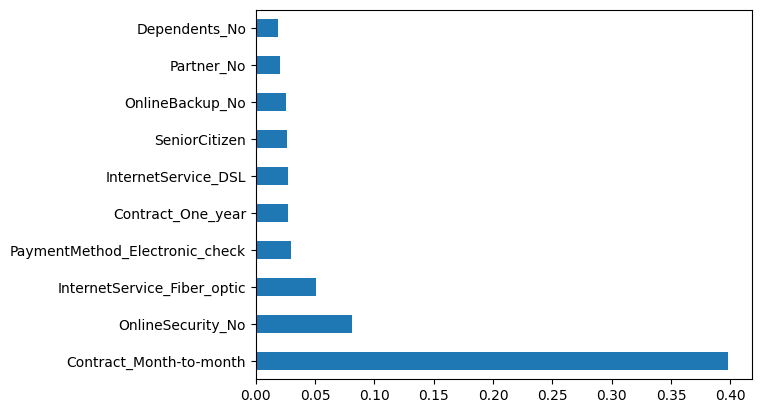

In [24]:
# To get the weights of all the variables
weights = pd.Series(grid_search.best_estimator_.feature_importances_,
                 index=X.columns.values)
weights.sort_values(ascending = False)[:10].plot(kind='barh')

<Axes: >

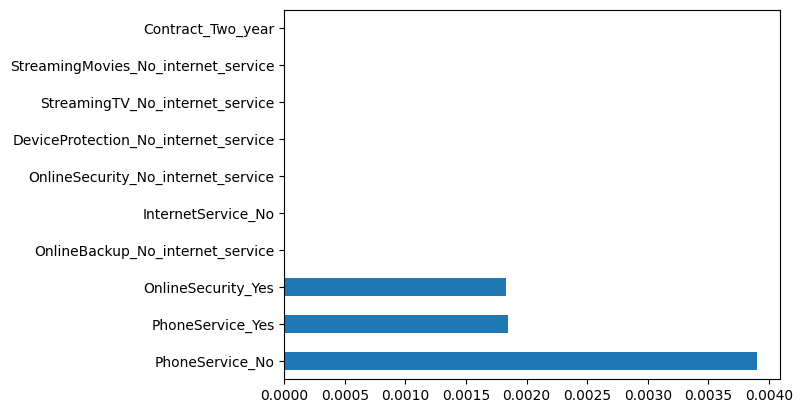

In [25]:
weights.sort_values(ascending = False)[-10:].plot(kind='barh')

In [26]:
# New row data as a list or Series
new_row_data = ['DecisionTreeClassifier',
                accuracy_score(y_test, y_test_pred_dec_tree),
                precision_score(y_test, y_test_pred_dec_tree),
                recall_score(y_test, y_test_pred_dec_tree),
                f1_score(y_test, y_test_pred_dec_tree),
                grid_search.best_params_,
                grid_search.best_score_,
                datetime.datetime.now()]

# Add the new row
tracker.loc[len(tracker)] = new_row_data

Now we try Random forest classifier

In [28]:
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "log2",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', max_leaf_nodes=30,
                       n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=50)

In [29]:
%%script false --no-raise-error

param_grid = {
    'n_estimators': [100, 200, 500,1000,1500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Set up GridSearchCV
# cv=5 means 5-fold cross-validation
# n_jobs=-1 means use all available processors for faster computation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [30]:
y_test_pred_rf=model_rf.predict(X_test)

In [31]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_rf = model_rf.predict_proba(X_test)[:, 1]

In [32]:
confusion_matrix(y_test, y_test_pred_rf)

array([[1135,  414],
       [ 303, 1246]])

<Axes: >

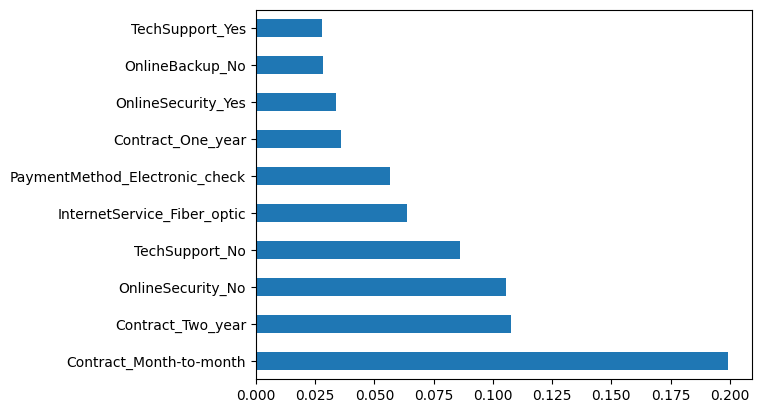

In [35]:
# To get the weights of all the variables
weights = pd.Series(model_rf.feature_importances_,
                 index=X.columns.values)
weights.sort_values(ascending = False)[:10].plot(kind='barh')

<Axes: >

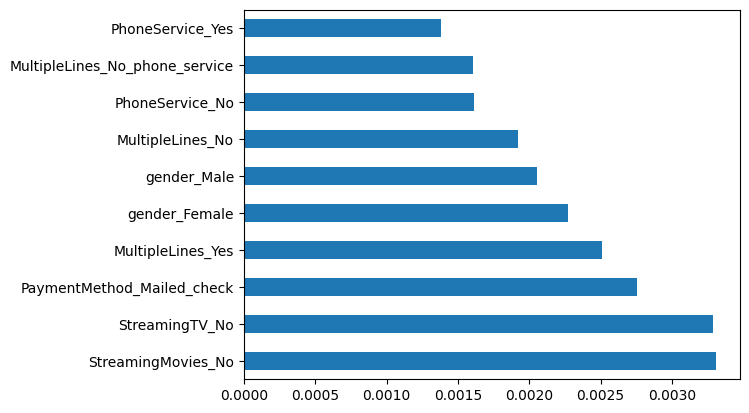

In [36]:
weights.sort_values(ascending = False)[-10:].plot(kind='barh')

In [37]:
# New row data as a list or Series
new_row_data = ['RandomForestClassifier',
                accuracy_score(y_test, y_test_pred_rf),
                precision_score(y_test, y_test_pred_rf),
                recall_score(y_test, y_test_pred_rf),
                f1_score(y_test, y_test_pred_rf),
                grid_search.best_params_,
                grid_search.best_score_]

# Add the new row
tracker.loc[len(tracker)] = new_row_data

Now we would try SVM

In [48]:
from sklearn.svm import SVC

model.svm = SVC(probability=True)


param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(model.svm, param_grid, refit=True, verbose=2, cv=5)

grid_search.fit(X_train,y_train)
y_test_pred_svm = grid_search.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  14.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  14.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  15.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  14.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  14.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.5s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  10.2s
[CV] END .......................C=0.1, gamma=0.

In [49]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_svm = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [50]:
confusion_matrix(y_test, y_test_pred_svm)

array([[1342,  207],
       [ 209, 1340]])

In [73]:
# New row data as a list or Series
new_row_data = ['SVM',
                accuracy_score(y_test, y_test_pred_svm),
                precision_score(y_test, y_test_pred_svm),
                recall_score(y_test, y_test_pred_svm),
                f1_score(y_test, y_test_pred_svm),
                grid_search.best_params_,
                grid_search.best_score_,
                datetime.datetime.now()]

# Add the new row
tracker.loc[len(tracker)] = new_row_data

Now we try XGBoost

In [75]:
from xgboost import XGBClassifier
model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,                # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,           # Use all available cores
    verbose=1
)

grid_search.fit(X_train, y_train)
y_test_pred_xgb = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [78]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_xgb = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [79]:
confusion_matrix(y_test, y_test_pred_xgb)

array([[1198,  351],
       [ 170, 1379]])

<Axes: >

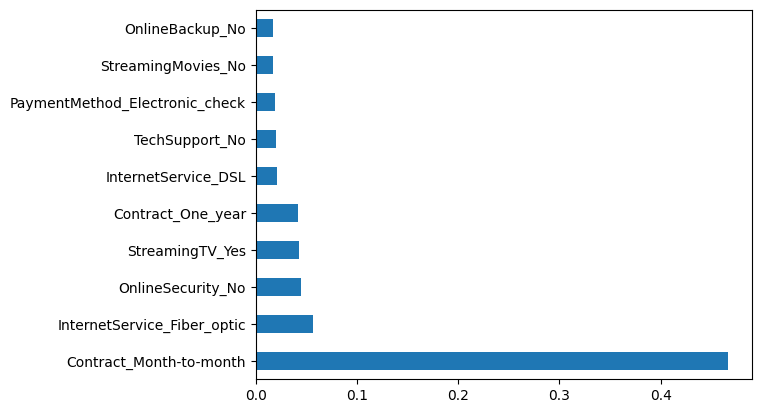

In [82]:
# To get the weights of all the variables
weights = pd.Series(grid_search.best_estimator_.feature_importances_,
                 index=X.columns.values)
weights.sort_values(ascending = False)[:10].plot(kind='barh')

<Axes: >

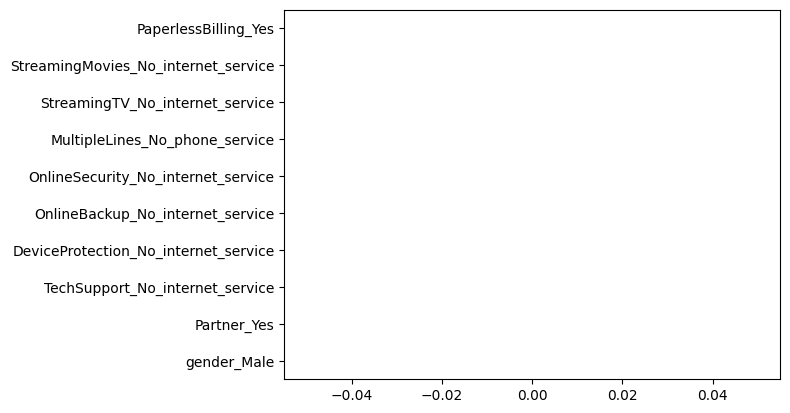

In [85]:
weights.sort_values(ascending = False)[-10:].plot(kind='barh')

In [86]:
# New row data as a list or Series
new_row_data = ['XGB',
                accuracy_score(y_test, y_test_pred_xgb),
                precision_score(y_test, y_test_pred_xgb),
                recall_score(y_test, y_test_pred_xgb),
                f1_score(y_test, y_test_pred_xgb),
                grid_search.best_params_,
                grid_search.best_score_,
                datetime.datetime.now()]

# Add the new row
tracker.loc[len(tracker)] = new_row_data

Now we try AdaBoost

In [88]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# 4. Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # Number of cross-validation splits
    scoring='accuracy', # Metric to optimize
    n_jobs=-1, # Use all available cores for parallel processing
    verbose=1
)
grid_search.fit(X_train,y_train)
y_test_pred_adaboost = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [89]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_adaboost = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [90]:
confusion_matrix(y_test, y_test_pred_adaboost)

array([[1134,  415],
       [ 301, 1248]])

<Axes: >

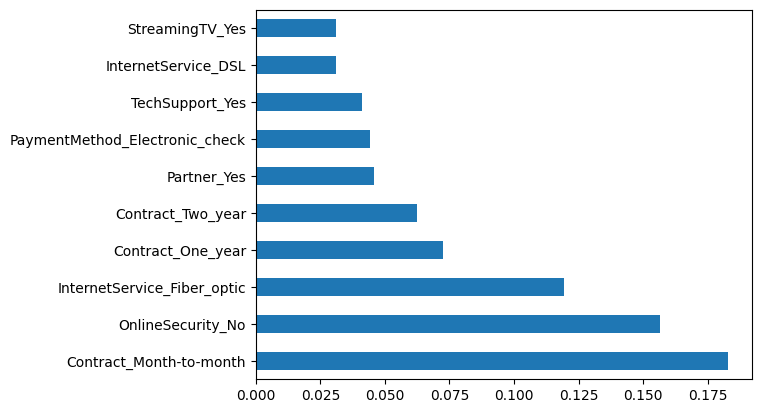

In [91]:
# To get the weights of all the variables
weights = pd.Series(grid_search.best_estimator_.feature_importances_,
                 index=X.columns.values)
weights.sort_values(ascending = False)[:10].plot(kind='barh')

<Axes: >

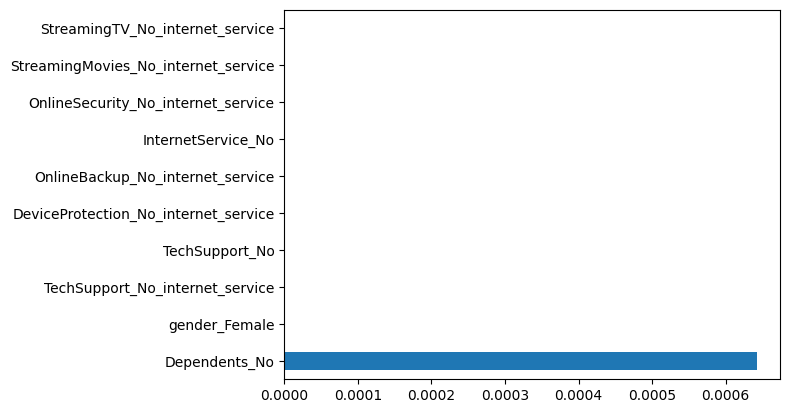

In [92]:
weights.sort_values(ascending = False)[-10:].plot(kind='barh')

In [93]:
# New row data as a list or Series
new_row_data = ['Adaboost',
                accuracy_score(y_test, y_test_pred_adaboost),
                precision_score(y_test, y_test_pred_adaboost),
                recall_score(y_test, y_test_pred_adaboost),
                f1_score(y_test, y_test_pred_adaboost),
                grid_search.best_params_,
                grid_search.best_score_,
                datetime.datetime.now()]

# Add the new row
tracker.loc[len(tracker)] = new_row_data

Now we try LGBoost

In [95]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'num_leaves': [10, 31, 50],
    'max_depth': [3, 5, -1], # -1 means no limit
    'boosting_type': ['gbdt', 'dart']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, # Number of cross-validation folds
    scoring='accuracy', # Metric for evaluation (e.g., 'accuracy', 'roc_auc', 'neg_mean_squared_error')
    verbose=1, # Controls the verbosity of the output
    n_jobs=-1 # Use all available cores for parallel processing
)
grid_search.fit(X_train, y_train)
y_test_pred_lgbm = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Info] Number of positive: 3614, number of negative: 3614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 7228, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [99]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_lgbm = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [100]:
confusion_matrix(y_test, y_test_pred_lgbm)

array([[1189,  360],
       [ 169, 1380]])

In [105]:
# New row data as a list or Series
new_row_data = ['LGBM',
                accuracy_score(y_test, y_test_pred_lgbm),
                precision_score(y_test, y_test_pred_lgbm),
                recall_score(y_test, y_test_pred_lgbm),
                f1_score(y_test, y_test_pred_lgbm),
                grid_search.best_params_,
                grid_search.best_score_,
                datetime.datetime.now()]

# Add the new row
tracker.loc[len(tracker)] = new_row_data

Check for model performance overview:
1. Plot the ROC/AUC curves

In [107]:
prob_dict = {'Logreg':y_test_prob_log_res,
             'DecisionTreeClassifier':y_test_prob_dec_tree,
             'RandomForestClassifier':y_test_prob_rf,
             'SVM':y_test_prob_svm,
             'XGB':y_test_prob_xgb,
             'Adaboost':y_test_prob_adaboost,
             'LGBM':y_test_prob_lgbm}

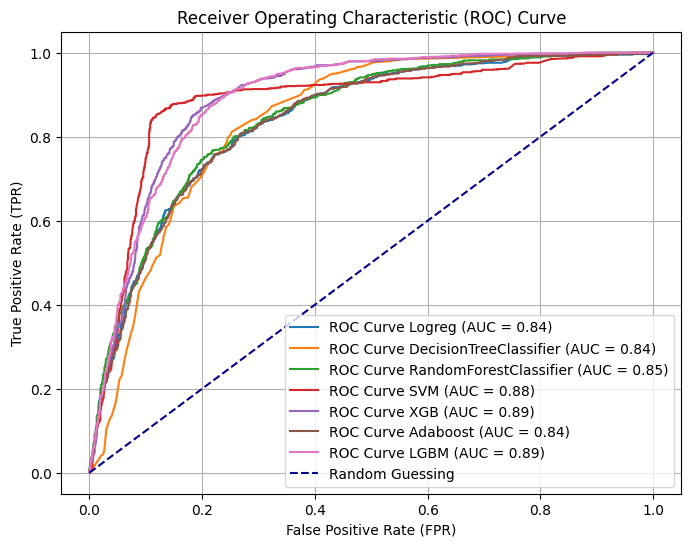

In [108]:


# 5. Plot the ROC curve
plt.figure(figsize=(8, 6))
for k,v in prob_dict.items():
  auc = roc_auc_score(y_test, v)
  fpr, tpr, thresholds = roc_curve(y_test, v)
  plt.plot(fpr, tpr, label=f'ROC Curve {k} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

Observations:

1. We see that ROC curve clearly outlines the performance charecteristics of all the models. AUC scores of XGB, LGBM are the highest and similar hence we selct XGB as out predictor model

2. For almost all the models for which we could plot the feature contributions/weights we see that Contract month to month basis prominently features as a factor directly influencing the Churn. This corroborates with out earlier exploration finding as well during EDA.

3. Also predicted by logistic regression, 2 month contract has the most negative relation with Churn as predicted by logistic regressions apart from DSL internet.